In [1]:
pip install heartpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.8 MB/s eta 0:00:00


In [2]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 29.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# insert this line of code to import the different function that we will use (they are functions that we saved in the files .py)
import sys
sys.path.insert(0,'/content/drive/MyDrive/tesi_UBFC-RPPG/function')

# FUNCTION

In [5]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mediapipe
import statistics
import heartpy as hp
import os
import random

#from SIGNAL_extraction_function import *
from VIDEO_load_function import *
from VIDEO_PreProcessing_function import *
from UBFC_RPPG_function import *
from google.colab.patches import cv2_imshow
from roi_mediapipe import *
from lpa_ica import *

from GREEN_1 import *
from POS_1 import *
from CHROM_1 import *
from ICA_1 import *
from PVB import *
from LGI import *

In [6]:
# EXTRACT THE SIGNAL FROM THE CROPPED IMAGES (AVERAGE OF THE PIXEL VALUES) (FOR PLOTTING SIGNAL ARE SAVED IN )
# comodo salvare tutti i diversi segnali associato ad uno stesso video in un singolo dizionario
def signal_extraction_plotting(cropped_video, num_valid_pixel):
  signal = {'R':[], 'G':[], 'B':[]}
  for i in range(cropped_video.shape[0]):
    signal['R'].append(np.sum(cropped_video[i,:,:,0])/num_valid_pixel[i])
    signal['G'].append(np.sum(cropped_video[i,:,:,1])/num_valid_pixel[i])
    signal['B'].append(np.sum(cropped_video[i,:,:,2])/num_valid_pixel[i])

  return signal

In [7]:
import scipy
import scipy.io
from scipy.signal import butter
def PB_filt(signal, LPF=0.75, HPF=2.5, fs=30):
  [b, a] = butter(1, [LPF / fs * 2, HPF / fs * 2], btype='bandpass')
  output = scipy.signal.filtfilt(b, a, np.double(signal))

  return output

In [8]:
def SNR(smooth_freqs, smooth_power_spectrum, GT_HR):
    def normalize(signal):
        min_val = np.min(signal)
        max_val = np.max(signal)
        normalized_signal = (signal - min_val) / (max_val - min_val)
        return normalized_signal

    # Normalize the power spectrum
    smooth_power_spectrum_norm = normalize(smooth_power_spectrum)

    # Find the index corresponding to the ground truth heart rate
    index_peak = np.argmin(np.abs(smooth_freqs - GT_HR))

    # Determine the Full Width Half Maximum (FWHM)
    peak_value = smooth_power_spectrum_norm[index_peak]
    half_max = peak_value / 2

    # Find indices where the power spectrum crosses the half-maximum value
    left_index = index_peak
    while left_index > 0 and smooth_power_spectrum_norm[left_index] > half_max:
        left_index -= 1

    right_index = index_peak
    while right_index < len(smooth_power_spectrum_norm) and smooth_power_spectrum_norm[right_index] > half_max:
        right_index += 1

    # Compute the power within the FWHM range
    power_peak = np.sum(smooth_power_spectrum_norm[left_index:right_index] ** 2)

    # Compute the total power
    power_total = np.sum(smooth_power_spectrum_norm ** 2)

    # Calculate SNR
    SNR = 10 * np.log10(power_peak / power_total)

    return SNR

In [9]:
def RI(smooth_freqs, smooth_power_spectrum):
    def normalize(signal):
        min_val = np.min(signal)
        max_val = np.max(signal)
        normalized_signal = (signal - min_val) / (max_val - min_val)
        return normalized_signal

    # Normalize the power spectrum
    smooth_power_spectrum_norm = normalize(smooth_power_spectrum)

    # Find the index corresponding to the frequency with maximum energy
    index_peak = np.argmax(smooth_power_spectrum_norm)

    # Determine the Full Width Half Maximum (FWHM)
    peak_value = smooth_power_spectrum_norm[index_peak]
    half_max = peak_value / 2

    # Find indices where the power spectrum crosses the half-maximum value
    left_index = index_peak
    while left_index > 0 and smooth_power_spectrum_norm[left_index] > half_max:
        left_index -= 1

    right_index = index_peak
    while right_index < len(smooth_power_spectrum_norm) and smooth_power_spectrum_norm[right_index] > half_max:
        right_index += 1

    # Compute the power within the FWHM range
    power_peak = np.sum(smooth_power_spectrum_norm[left_index:right_index] ** 2)

    # Compute the total power
    power_total = np.sum(smooth_power_spectrum_norm ** 2)

    # Calculate SNR
    RI = power_peak / power_total

    return RI

In [10]:
def algorithm(signal_RGB,ROI_tensor_im,GT, method):
  FS = 30

  if method == 'POS':
    rPPG = POS(signal_RGB,FS)
  elif method == 'CHROM':
    rPPG = CHROME(signal_RGB,FS)
  elif method == 'GREEN':
    rPPG = GREEN(signal_RGB,FS)
  elif method == 'ICA':
    rPPG = ICA(signal_RGB,FS)
  elif method == 'PBV':
    rPPG = PBV(ROI_tensor_im)
  elif method == 'LGI':
    rPPG = LGI(ROI_tensor_im)

  rPPG_filtered = PB_filt(rPPG, LPF=0.75, HPF=2.5, fs=30)

  sample_rate=30
  smooth_freqs, smooth_power_spectrum, max_freq, max_power = compute_power_spectrum(rPPG_filtered, sample_rate,rPPG_filtered.shape[0])
  pred = max_freq

  rmse = math.pow(pred-GT,2)
  mae = abs(pred-GT)
  snr = SNR(smooth_freqs, smooth_power_spectrum, GT)
  ri = RI(smooth_freqs, smooth_power_spectrum)

  plt.subplots()
  plt.plot(rPPG_filtered)

  #plt.subplots()
  #plt.plot(smooth_freqs,smooth_power_spectrum)

  return mae, rmse, snr, ri

In [11]:
def skin_segmentation_2(image, roi):
  mp_face_mesh = mediapipe.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
  results = face_mesh.process(image)
  landmarks = results.multi_face_landmarks[0]

  #define the roi to segment
  if roi == 'face':
    face_oval = mp_face_mesh.FACEMESH_FACE_OVAL

    df = pd.DataFrame(list(face_oval), columns = ["p1", "p2"])
    routes_idx = []
    p1 = df.iloc[0]["p1"]
    p2 = df.iloc[0]["p2"]

    for i in range(0, df.shape[0]):
      obj = df[df["p1"] == p2]
      p1 = obj["p1"].values[0]
      p2 = obj["p2"].values[0]
      route_idx = []
      route_idx.append(p1)
      route_idx.append(p2)
      routes_idx.append(route_idx)

  if roi == 'fore_head':
    fore_head = [(109,108),(108,107),(107,9),(9,336),(336,337),(337,338),(338,10),(10,109)]
    #fore_head = [(67,69),(69,108),(108,151),(151,337),(337,299),(299,297),(297,338),(338,10),(10,109),(109,67)] #risultati final_mediapipe
    routes_idx = fore_head

  if roi == 'cheek_sx':
    cheek_sx = [(117,123),(123,147),(147,187),(187,205),(205,36),(36,142),(142,100),(100,120),(120,119),(119,118),(118,117)]
    #cheek_sx = [(230,120),(120,100),(100,36),(36,205),(205,50),(50,118),(118,230)] #piccole spostate verso centro
    #cheek_sx = [(117,123),(123,187),(187,205),(205,101),(101,118),(118,117)] #risultati final_mediapipe
    routes_idx = cheek_sx

  if roi == 'cheek_dx':
    cheek_dx = [(346,352),(352,411),(411,425),(425,266),(266,329),(329,349),(349,348),(348,347),(347,346)]
    #cheek_dx = [(450,349),(349,329),(329,266),(266,425),(425,280),(280,347),(347,450)]  #piccole spostate verso centro
    #cheek_dx = [(340,352),(352,280),(280,425),(425,266), (266,330), (330,347), (347,346),(346,340)] #risultati final_mediapipe
    routes_idx = cheek_dx

  #############################################################################
  #extaction of the ROI
  routes = []
  for source_idx, target_idx in routes_idx:

    source = landmarks.landmark[source_idx]
    target = landmarks.landmark[target_idx]
    relative_source = (int(image.shape[1] * source.x), int(image.shape[0] * source.y))
    relative_target = (int(image.shape[1] * target.x), int(image.shape[0] * target.y))
    #cv2.line(image, relative_source, relative_target, (255, 255, 255), thickness = 2)
    routes.append(relative_source)
    routes.append(relative_target)

  mask = np.zeros((image.shape[0], image.shape[1]))
  mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
  mask = mask.astype(bool)
  out = np.zeros_like(image)
  out[mask] = image[mask]

  return out

In [12]:
'''
estensione del skin segmentation non ad una sola immagine, ma viene applicata ad un video -> quindi abbiamo richiamato la funzione definita sopra per astenderla a tutti i frame del video
'''
def skin_segm_video_2(video, roi, tensor_shape=True):
  cropped_image = []
  heigth = 0
  width = 0
  for iii in range(video.shape[0]):
    temp = skin_segmentation_2(video[iii], roi)
    [min_x, max_x, min_y, max_y] = valid_image(temp)

    temp_width = max_x - min_x
    temp_heigth = max_y - min_y

    if temp_heigth > heigth:
      heigth = temp_heigth
    if temp_width > width:
      width = temp_width

    cropped_image.append(temp)
  cropped_image = np.array(cropped_image)
  print('SEGMENTATION: DONE')

  final_image = []
  number_valid_pixel = []
  for k in range(cropped_image.shape[0]):
    [min_x, max_x, min_y, max_y] = valid_image(cropped_image[k])

    # to count the pixels != 0 so in the mean we consider only the number of valid pixels
    mask = np.any(cropped_image[k] != 0, axis=-1)
    non_zero_coords = np.argwhere(mask).shape[0]
    number_valid_pixel.append(non_zero_coords)

    if tensor_shape:
      final_image.append(cropped_image[k, min_x:min_x+width ,min_y:min_y+heigth , :])
    else:
      final_image.append(cropped_image[k, min_x:max_x, min_y:max_y , :])

  print('CROPPING: DONE')

  return np.array(final_image), number_valid_pixel

In [13]:
def compute_padding(fs,length): #length è in sec
  fn = fs/2
  N = (2*fn)/(0.5/60)
  half_pad = round((N - length*fs)/2)

  return half_pad

In [14]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.fft import fft
# input : riceve segnale già filtrato
# output : restituisce come output la predizione del BPM
def compute_power_spectrum(signal, fs, leng):
    """Compute the power spectrum of a signal and find the frequency corresponding to the maximum peak."""
    half_padding = compute_padding(fs,leng/fs) #3 sec è la lunghezza del segnale

    y_pad = np.pad(signal,half_padding)
    x_pad = np.arange(-half_padding/fs,half_padding/fs+(leng/fs),1/fs)

    fft_result = fft(y_pad)

    fn = fs/2 #questo rappresenta la frequenza massima che riusciamo a indentificare (la Nyquist frequecy)
    N = x_pad.shape[0] #il numero di samples nel dominio della frequenza è uguale a quello nel dominio del tempo
    fDelta = 2*(fn/N) #dobbiamo ricordare che lo spettro èè simmetrico (per le frequenze positive e negative). Per questa ragione, il numero di samples deve essere distributo in entrambi gli assi. Questo giustifica il 2 dato che sarebbe fn/(N/2)
    x_f = np.arange(-fn,fn,fDelta)

    index_max = np.where(np.abs(fft_result[:N//2]) == np.max(np.abs(fft_result[:N//2])))[0][0]
    GT_HR = x_f[N//2:][index_max]*60

    return  x_f[N//2:], np.abs(fft_result[:N//2]), GT_HR, index_max



In [15]:
def land_coordinates(img, RGB = True):
  temp_img =  np.copy(img) #ATTENTION: IT'S CRUCIAL TO CREATE A COPY OTHERWISE WHEN WE CHANGE temp_img, also the img variable will change (same memory address)
  # Initialize MediaPipe Face Mesh
  mp_face_mesh = mediapipe.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh() #refine_landmarks=True

  # Convert the BGR image to RGB
  if not(RGB):
    rgb_image = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
  else:
    rgb_image = temp_img

  # Perform facial landmark detection
  results = face_mesh.process(rgb_image)

  # extract connnection
  connection_list = []
  for connection in mp_face_mesh.FACEMESH_TESSELATION:
    connection_list.append(connection)


  # Draw the landmarks on the image
  if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks: # very long list of dictionary, each containing the 3D coordinates of a landmarks ({x:, y:, z:})

        landCoord = {'x': [], 'y':[], 'z':[]}

        for landmark in face_landmarks.landmark: # we are extracting only the coordinates

          # Convert normalized coordinates to pixel values
          x = landmark.x * temp_img.shape[1]
          y = landmark.y * temp_img.shape[0]
          z = landmark.z * max(temp_img.shape)

          landCoord['x'].append(x)
          landCoord['y'].append(y)
          landCoord['z'].append(z)

          # Draw the landmark on the image
          #cv2.circle(temp_img, (x, y), 1, (0, 0, 255), thickness=-1)

  # Display the image
  #cv2_imshow(temp_img[:,:,::-1])

  return landCoord, connection_list

In [16]:
def tracking_lands(marks, video_RGB): #marks [p1,p2,p3] (list)

  coordinates = {marks[0]:[],marks[1]:[],marks[2]:[]} #contain coords of landmarks over the different frames (each landmark corresponds to a specific ROI)
  for i in range(video_RGB.shape[0]):
    frame = video_RGB[i]
    land_coord, _ = land_coordinates(frame, RGB=True)
    for point in coordinates.keys():
      #coordinates[point].append((land_coord['x'][point],land_coord['y'][point],land_coord['z'][point])) #extraction coordinates single frame for each landmark
      coordinates[point].append((int(land_coord['x'][point]),int(land_coord['y'][point]))) # in this case we keep only the x,y coords in int format since they represent the initial pixel of the lpa

  return coordinates

In [17]:
def draw_black_rectangle_on_frame(frame, top_left, bottom_right):
    """
    Disegna un rettangolo nero su un singolo frame.

    Args:
    - frame: Singolo frame come array NumPy.
    - top_left: Vertice superiore sinistro del rettangolo (x, y).
    - bottom_right: Vertice inferiore destro del rettangolo (x, y).

    Returns:
    - frame: Il frame modificato con il rettangolo nero.
    """
    # Disegna un rettangolo nero (colore nero è [0, 0, 0]) con spessore -1 (pieno)
    cv2.rectangle(frame, top_left, bottom_right, color=(0, 0, 0), thickness=-1)
    return frame

# CODE

In [18]:
def obstraction(video_RGB, plot_bool=True):
  fh_point = 151
  dx_point = 330
  sx_point = 101

  coordinates_lands = tracking_lands([fh_point, dx_point, sx_point], video_RGB) # output data as (x,y) format

  video_array = np.copy(video_RGB) #video copy

  ones = np.arange(20,50)
  #random = (ones)

  for i in ones: #for i_th frame
    # extract coordinates landmarks
    fh = coordinates_lands[fh_point][i]
    dx = coordinates_lands[dx_point][i]
    sx = coordinates_lands[sx_point][i]

    #fore_head (coordinates rectangles are in the format (x,y))
    tl_fh = (fh[0]-40, fh[1]-30)
    br_fh = (fh[0]+40, fh[1]-5)
    tl_fh1 = (fh[0]+20, fh[1]-20)
    br_fh1 = (fh[0]+50, fh[1]+10)
    tl_fh2 = (fh[0]-50, fh[1]-20)
    br_fh2 = (fh[0]-20, fh[1]+10)

    #cheek_dx
    tl_dx = (dx[0]+13, dx[1]-10)
    br_dx = (dx[0]+35, dx[1]+30)

    #cheek_sx
    tl_sx = (sx[0]-40, sx[1]-10)
    br_sx = (sx[0]-15, sx[1]+30)

    #apply the ractangle
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh, br_fh)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh1, br_fh1)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh2, br_fh2)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_dx, br_dx)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_sx, br_sx)


  if plot_bool:
    plt.imshow(video_array[0])
    plt.scatter(np.array([fh[0],sx[0],dx[0]]),np.array([fh[1],sx[1],dx[1]]))

  return video_array, coordinates_lands

In [19]:
def obstraction1(video_RGB, plot_bool=True):
  fh_point = 151
  dx_point = 330
  sx_point = 101

  coordinates_lands = tracking_lands([fh_point, dx_point, sx_point], video_RGB) # output data as (x,y) format

  video_array = np.copy(video_RGB) #video copy

  ones = np.arange(20,50)
  random = (ones)

  for i in range(100): #for i_th frame
    # extract coordinates landmarks
    fh = coordinates_lands[fh_point][i]
    dx = coordinates_lands[dx_point][i]
    sx = coordinates_lands[sx_point][i]

    #fore_head (coordinates rectangles are in the format (x,y))
    tl_fh = (fh[0]-40, fh[1]-30)
    br_fh = (fh[0]+40, fh[1]-5)
    tl_fh1 = (fh[0]+20, fh[1]-20)
    br_fh1 = (fh[0]+50, fh[1]+10)
    tl_fh2 = (fh[0]-50, fh[1]-20)
    br_fh2 = (fh[0]-20, fh[1]+10)

    #cheek_dx
    tl_dx = (dx[0]+13, dx[1]-10)
    br_dx = (dx[0]+35, dx[1]+30)

    #cheek_sx
    tl_sx = (sx[0]-40, sx[1]-10)
    br_sx = (sx[0]-15, sx[1]+30)

    #apply the ractangle
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh, br_fh)
    #video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh1, br_fh1)
    #video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_fh2, br_fh2)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_dx, br_dx)
    video_array[i] = draw_black_rectangle_on_frame(video_array[i], tl_sx, br_sx)
  if plot_bool:
    plt.imshow(video_array[99])
    plt.scatter(np.array([fh[0],sx[0],dx[0]]),np.array([fh[1],sx[1],dx[1]]))

  return video_array, coordinates_lands

## IMPORT VIDEO

In [20]:
patient = 42
[video, fps_video] = import_video('/content/drive/MyDrive/DATASET_2/subject' + str(patient) + '/vid.avi')

In [21]:
video_RGB = []
for i in video:
  video_RGB.append(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
video_RGB = np.array(video_RGB)
leng = 100 #300
video_RGB = video_RGB[:leng]

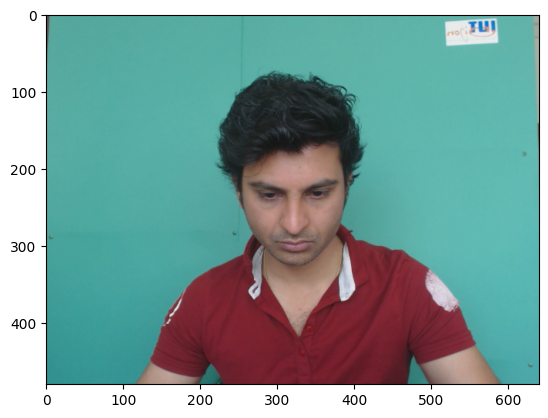

In [22]:
plt.imshow(video_RGB[0])

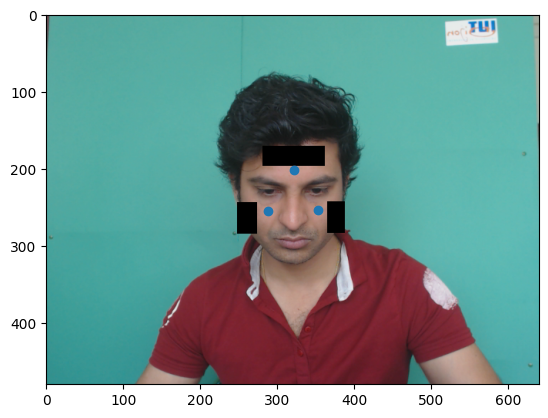

In [23]:
# INSERT OBSTRACTION
video_array, _ = obstraction1(video_RGB)

## GROUND-TRUTH

In [24]:
def PPG_to_HR(signal, plotting = True, type = 'Tool_box'):
  if type == 'Tool_box':
    working_data, measures = hp.process(signal, sample_rate=30)
    HR_toolbox = measures['bpm']
    if plotting:
      hp.plotter(working_data, measures)
    return HR_toolbox
  else:
    print('type: Tool_box')

In [25]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

GT_rPPG = np.array(import_UBFC_RPPG_ground_truth(num_patient=patient))
sample_rate = 30
smooth_freqs, smooth_power_spectrum, GT_HR, max_power = compute_power_spectrum(GT_rPPG[0][:leng], sample_rate,leng)

## PRE-ALLOCATE DATAFRAME SPACE

In [26]:
# Preallocate a DataFrame with NaN values (first iteration)
# columns : ROIs
# rows : GT (ground truth), greemn, ica, pos, chrom
rows = 6
columns = ['fore_head', 'cheek_sx', 'cheek_dx']
#columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9']
df = pd.DataFrame(np.nan, index=range(rows), columns=columns)
df1 = pd.DataFrame(np.nan, index=range(rows), columns=columns)
df2 = pd.DataFrame(np.nan, index=range(rows), columns=columns)
df3 = pd.DataFrame(np.nan, index=range(rows), columns=columns)
# Specify the filename
filename = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/black/MAE/med_AE_' + str(patient) + '.csv'
filename1 = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/black/RMSE/med_SE_' + str(patient) + '.csv'
filename2 = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/black/SNR/med_SNR_' + str(patient) + '.csv'
filename3 = '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/black/RI/med_RI_' + str(patient) + '.csv'

#filename = '/content/drive/MyDrive/tesi_UBFC-RPPG/pre_processing/merged_code/mediapipe_new_' + str(patient) + '.csv'

# Check if the file exists
if os.path.exists(filename):
    print(f"The file '{filename}' exists.")
else:
  print(f"The file '{filename}' does not exist.")
  df.to_csv(filename, index=False)

if os.path.exists(filename1):
    print(f"The file '{filename1}' exists.")
else:
  print(f"The file '{filename1}' does not exist.")
  df.to_csv(filename1, index=False)

if os.path.exists(filename2):
    print(f"The file '{filename2}' exists.")
else:
  print(f"The file '{filename2}' does not exist.")
  df.to_csv(filename2, index=False)

if os.path.exists(filename3):
    print(f"The file '{filename3}' exists.")
else:
  print(f"The file '{filename3}' does not exist.")
  df.to_csv(filename3, index=False)

The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/black/MAE/med_AE_42.csv' exists.
The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/black/RMSE/med_SE_42.csv' exists.
The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/black/SNR/med_SNR_42.csv' exists.
The file '/content/drive/MyDrive/tesi_UBFC-RPPG/tesi/mediapipe/black/RI/med_RI_42.csv' exists.


## ROI EXCTRACTION

### 1. ROI MEDIAPIPE

In [27]:
import time

In [28]:
# we need to re-run the code for each ROI otherwise we will run out of memory.
# So we pre-allocate space for the dataframe only with the first iteration; then we import it and add the new values
#selected_roi = 'cheek_dx'
#selected_roi = 'cheek_sx'
selected_roi = 'fore_head'

start_time = time.time()

ROI_tensor_im, num_valid_pixel = skin_segm_video_2(video_array, roi=selected_roi)
signal_RGB = signal_extraction_plotting(ROI_tensor_im, num_valid_pixel)
print("--- %s seconds ---" % (time.time() - start_time))

SEGMENTATION: DONE
CROPPING: DONE
--- 7.841050386428833 seconds ---


In [29]:
signal_RGB = signal_extraction_plotting(ROI_tensor_im, num_valid_pixel)
#signal_RGB.keys() #raw signals (RGB channels)

In [30]:
df = pd.read_csv(filename)
df1 = pd.read_csv(filename1)
df2 = pd.read_csv(filename2)
df3 = pd.read_csv(filename3)

(1, 3, 100)


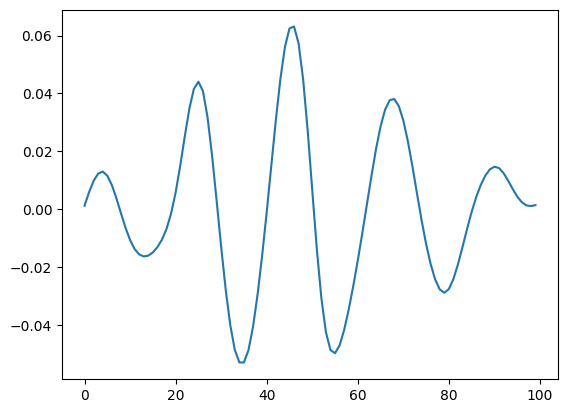

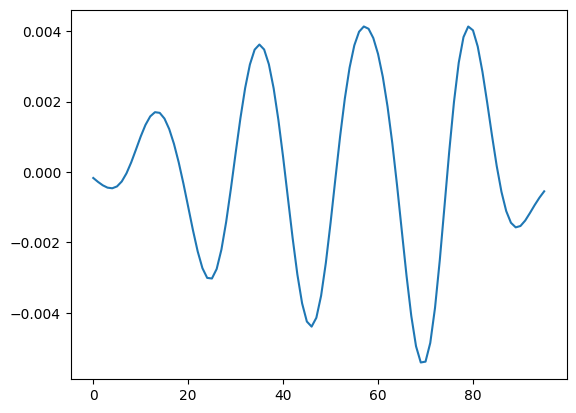

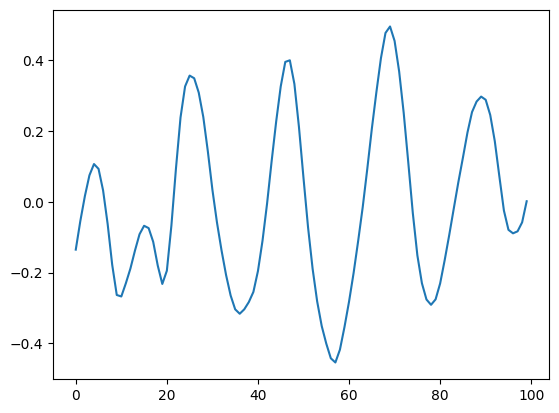

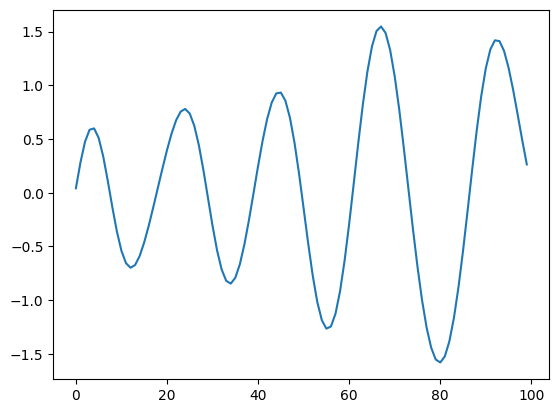

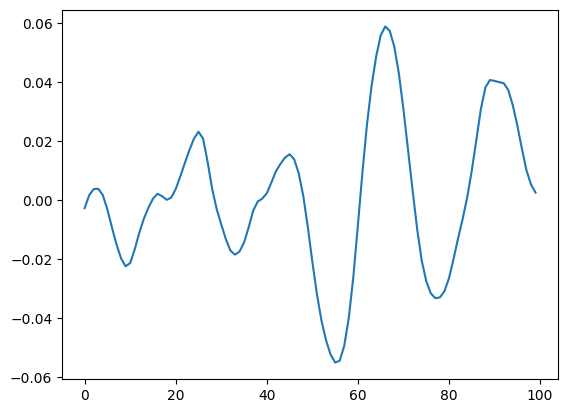

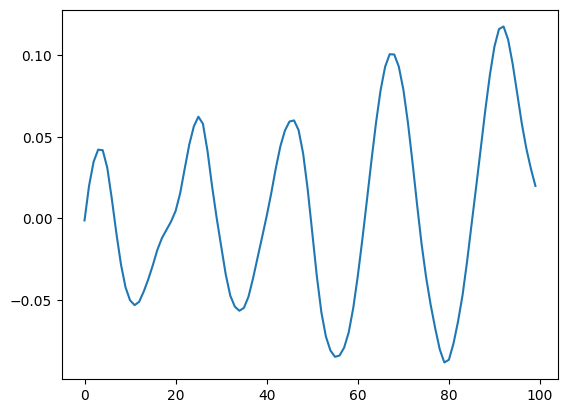

In [31]:
result = []
result1 = []
result2 = []
result3 = []
for i in ['POS', 'CHROM','GREEN', 'ICA', 'PBV','LGI']: # apply the different algorithm on the same ROI
  a,b,c,d = algorithm(signal_RGB,ROI_tensor_im,GT_HR, method=i)
  result.append(a)
  result1.append(b)
  result2.append(c)
  result3.append(d)
df.loc[0:,selected_roi] = result
df1.loc[0:,selected_roi] = result1
df2.loc[0:,selected_roi] = result2
df3.loc[0:,selected_roi] = result3

In [32]:
df.to_csv(filename, index=False)
df1.to_csv(filename1, index=False)
df2.to_csv(filename2, index=False)
df3.to_csv(filename3, index=False)